# Project: Investigate TMDb Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This report will investigate the TMDb movie dataset.
Questions to be explored are as follows:

1. What kind of correlation can observed among properties?
2. Which genres are most popular from year to year?
3. What kind of key words are most frequently used from year to year?
4. Who are the directors earned most revenue?
5. Who are the directors with highest ratings?
6. Who are the actors most frequently casted actors?


In [1]:
# Use this cell to set up import statements for all of the packages that you plan to use.
%matplotlib inline

import pandas as pd
import numpy as np
import csv
import time
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from pandas.plotting import scatter_matrix

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling

In this section, the data will be checked before exploring analysis. Check items are as follows:
1. Missing values
2. Duplicated data
3. Inappropriate data type

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

df = pd.read_csv('/Users/masa/Downloads/Udacity/tmdb-movies.csv')

# 1. Check if there are any missing values
df.info() 

# 2. Check if there are any duplicated rows
print("Duplicated: {}".format(str(df.duplicated().sum())))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

### Observation
The above result shows some problems with the raw dataset as follows:
1. There are one duplicate record.
2. Some fields have missing values, homepage, director, tagline, keywords, overview, genres, and production companies.
3. The data type for the Adjusted dollor amount field, such as budget_adj, revenue_adj, is 'float'. 

### Data Cleaning
In order to explore the data accurately, the dataset is to be adjusted as follows:
1. De-dulicate the records
2. Filling the missing values with string 'missing'.
3. Convert the data type from float to integer for dollar amount fields (i.e. 'budget_adj' and  'revenue_adj').

In [3]:
# 1. De-duplicate
df.drop_duplicates(inplace=True)

# 2. Filling missing values
df.fillna('missing',inplace=True)

# 3. Convert adjusted dollar fields from float to integer
df.revenue_adj= df.revenue_adj.astype(np.int64)
df.budget_adj = df.budget_adj.astype(np.int64)

# 4. Make sure there are no duplicated record nor missing values

df.info() # no missing values

print("Duplicated: {}".format(str(df.duplicated().sum()))) # no duplicated records

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10865 non-null object
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10865 non-null object
homepage                10865 non-null object
director                10865 non-null object
tagline                 10865 non-null object
keywords                10865 non-null object
overview                10865 non-null object
runtime                 10865 non-null int64
genres                  10865 non-null object
production_companies    10865 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj           

The above reults is showing there are no more missing data, and duplicated recoreds. Data type is also converted accordingly.


###  Defining Common Functions
In this section, firstly common functions that are to be used throughout the exploration are to be defined.<BR>
Then each questions outlined in the introduction are to be explored.

In [22]:
# This code is provided by reviewer.
# It devide a delimited column into multiple columns
# newly generated columns holds either 0 or 1, so you can use it as a flag.
# in this way, no need to generate duplicated record, but you can still calcurate necessary information.
# for example, if you need to count the 'Action', just sum the Action field or count with query filtering 'Action ==1'

# This code runs really fast. I wish I was eable to find this code while researcing.
"""
df = pd.concat([df, df["genres"].str.get_dummies(sep="|")], axis=1)
df.info()
df.head()
"""

# However, what happens if it is used for filed like cast or keywords ?
"""
df = pd.concat([df, df["keywords"].str.get_dummies(sep="|")], axis=1)
df.info()
"""
#  it took too long, maybe generating to many columns

# Can you do something like aggregate by cast?
# looks like the parameter 'axis' is the answer?
"""
df = pd.concat([df, df["cast"].str.get_dummies(sep="|")], axis=0)
df.info()
df.head()
"""
# nope, it doesn't work as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 5 columns):
0    10865 non-null object
1    8514 non-null object
2    5078 non-null object
3    1980 non-null object
4    541 non-null object
dtypes: object(5)
memory usage: 829.3+ KB


In [4]:
def build_splitted_df_by_key(df, field, delimiter="|"):
    """
    This function does the following:
    1. split the specified field delimitted with "|"
    2. split a record into multiple records with delimited field values
    
    df: input DataFrame
    field: name of the field to be splitted, delimitted by "|", such as 'cast','genres','keywords'
    delimiter: any delimiter character, default = "|"
    """

    # 1. initialize a list
    result_list = []

    # 2. Convert the DF to a dictionary for faster processing
    movies = df.to_dict('record')

    # 3. split a record into multiple records 
    #i=0
    for movie in movies:
        #i+=1

        # 3-1 split the specified field by delimiter
        keys = movie[field].split(delimiter)

        # 3-2 for each delimited value, generate a new movie record
        for key in keys:
            new_movie = pd.Series(movie)
            new_movie[field]=key
            result_list.append(new_movie)
        #if i>5:
        #    break

    # 4. convert the list into DataFrame and return
    return pd.DataFrame(result_list)

# test code
if False:
    df3 = build_splitted_df_by_key(df, 'cast')
    df3.info()
    df3.head()


In [5]:
def plot_barh_by_year_and_person(df, key_field, from_year, to_year, title):
    """
    This function does the following:
    1. compute the sum of revenue_adj between specified year
    2. plot a horizontal bar chart
    
    Parameters:
        df: input DataFrame
        key_field: name of the field to be used as summary key, such as 'cast','genres', etc.
        from_year, to_year: years to specity from year to year  
        title: string to be used as a graph title
    """
    df_sum_by_person = (df.query('{} <= release_year <= {}'.format(str(from_year),str(to_year))).groupby([key_field]).revenue_adj.sum()/1000000000).sort_values(ascending=False).head(10)
    df_sum_by_person.sort_values(ascending=True).plot(kind='barh')
    plt.title(title)


<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: What are the correlation among the properties?

Firstly, let's see if there are any corelation among properties by looking at scatter chart as below.

Text(0.5,0.98,'Correlations among properties')

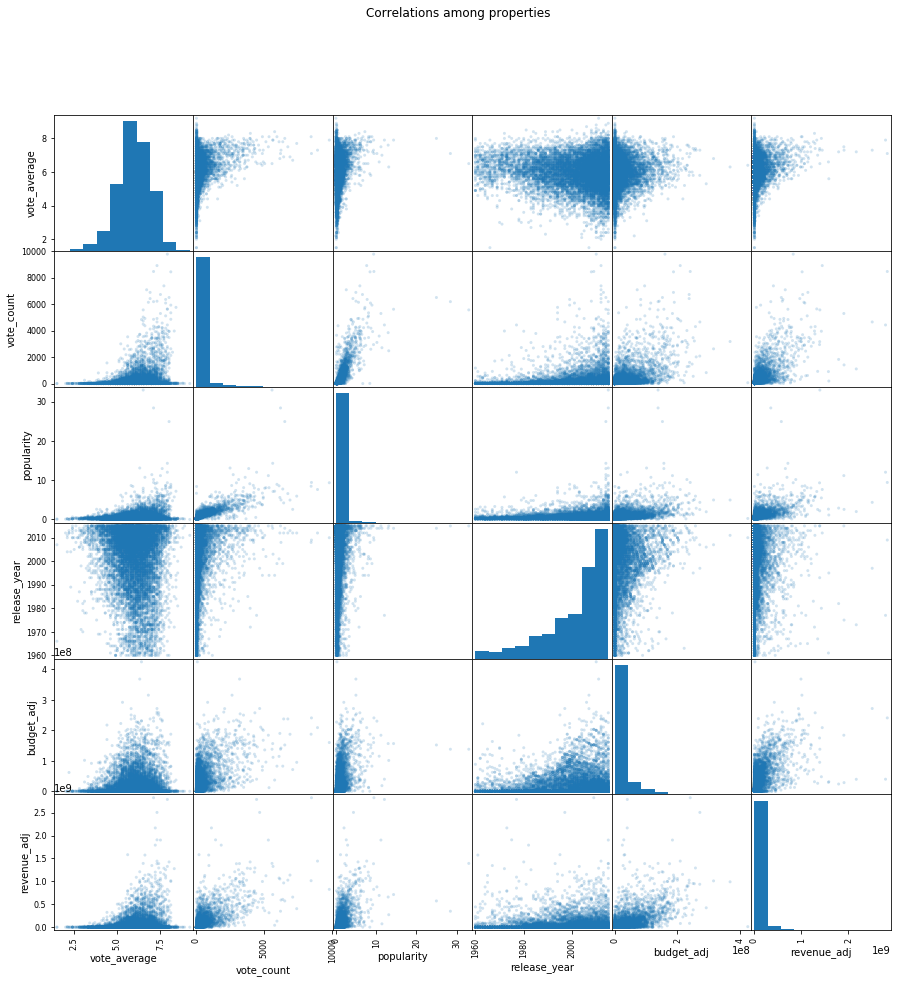

In [6]:
dummy = scatter_matrix(df[['vote_average','vote_count','popularity','release_year','budget_adj','revenue_adj']], alpha=0.2, figsize=(15, 15), diagonal='hist')
plt.suptitle('Correlations among properties')

### Observation
According to the above scatter matrix, positive corelation are observed as follows:
* vote average vs vote count, popularity, budget, and revenue.
* vote_count vs popularity, budget, revenue
* budget vs revenue

Interestingly, there seems to be positive correlation between release year and most of the other properties except the rating(vote_average). Let's dig in to see what the implications are.


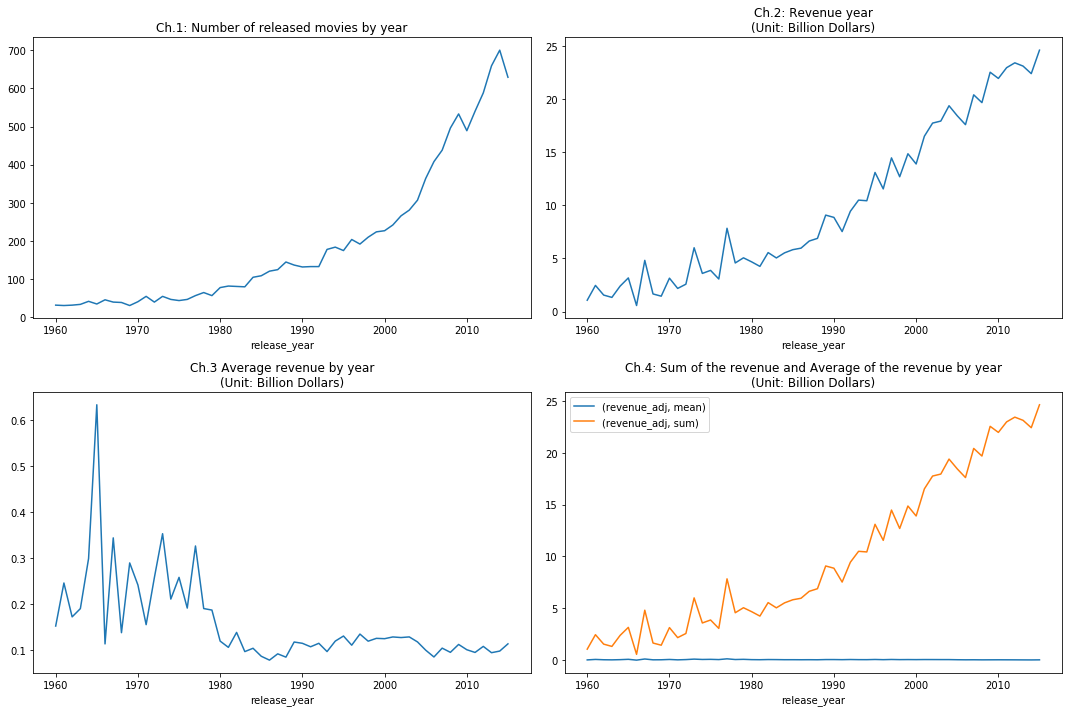

In [7]:
plt.subplots(figsize=(15,10))

plt.subplot(2,2,1)
plt.title('Ch.1: Number of released movies by year')
plt.tight_layout()
df.groupby('release_year').id.count().plot()

plt.subplot(2,2,2)
plt.title('Ch.2: Revenue year\n(Unit: Billion Dollars)')
(df.groupby('release_year').revenue_adj.sum()/1000000000).plot()
plt.tight_layout()

plt.subplot(2,2,3)
plt.title('Ch.3 Average revenue by year\n(Unit: Billion Dollars)')
(df.query('revenue_adj != 0').groupby('release_year').revenue_adj.mean()/1000000000).plot()
plt.tight_layout()

ax=plt.subplot(2,2,4)
(df.groupby('release_year').agg({'revenue_adj':{'sum','mean'}})/1000000000).plot(ax=ax,title='Ch.4: Sum of the revenue and Average of the revenue by year\n(Unit: Billion Dollars)')
plt.legend(loc='best')
plt.tight_layout()

### Observation
* Both number of movies released and annual revenue have been increasing.(Ch.1 and Ch.2)
* On the contrary, average revenue per a movie seems to be staying same level for last 20 years since around 1990s.(Ch.3)
* Ch.4 highlights above findings in the fluctuations in the number of released movies and average revenue.

### Research Question 2: Which genres are most popular from year to year? 

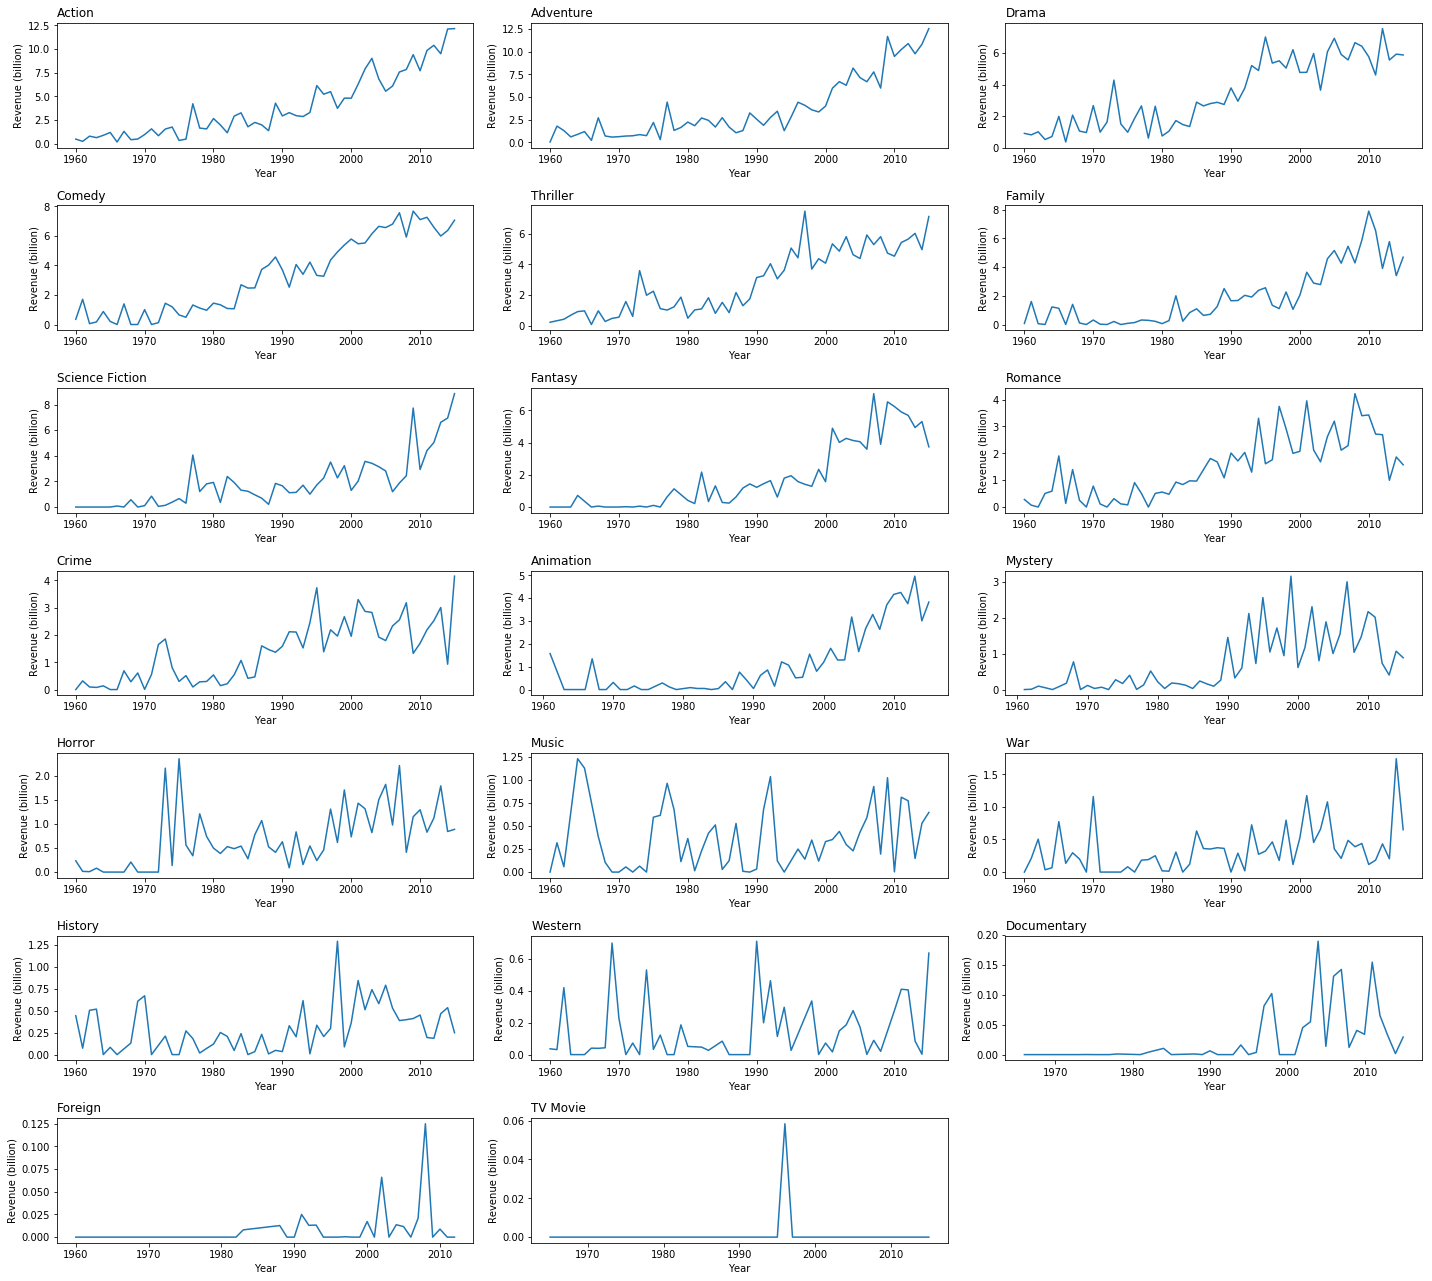

In [8]:
# 1. Split the df based on genres
try:
    df_by_genres
except NameError:
    df_by_genres = build_splitted_df_by_key(df,'genres')

if df_by_genres.empty:
    df_by_genres = build_splitted_df_by_key(df,'genres')
    
# 2. Take top 10 genres for readability
top_genres = df_by_genres.query('genres != "missing"').groupby(['genres']).revenue_adj.sum().sort_values(ascending=False)#.head(10)

# 3. Plot a Line charts

## 3-1. Define the figsize
plt.subplots(figsize=(20,20))

## 3-2. for each genres, plot a line
num=0
for genre in top_genres.index:
    num+=1
    df_genre = df_by_genres.query('genres == "{}"'.format(genre)).groupby(['release_year']).revenue_adj.sum()/1000000000
    plt.subplot(8,3, num)
    # Add title and labels
    plt.title(genre, loc='left')
    plt.xlabel('Year')
    plt.ylabel('Revenue (billion)')
    plt.tight_layout()
    plt.plot(df_genre)

* Genres (from Action to Animation) showing increasing curve in revenue. Most of the genres commonly show drastic increase since mid 1990s - 2000.
* This is likely to be due to the increase in number of released titles as explored earlier in question 1.

To see the transition amongst the genres, it might be more appropriate to look into revenue shares rather than revenue amount.


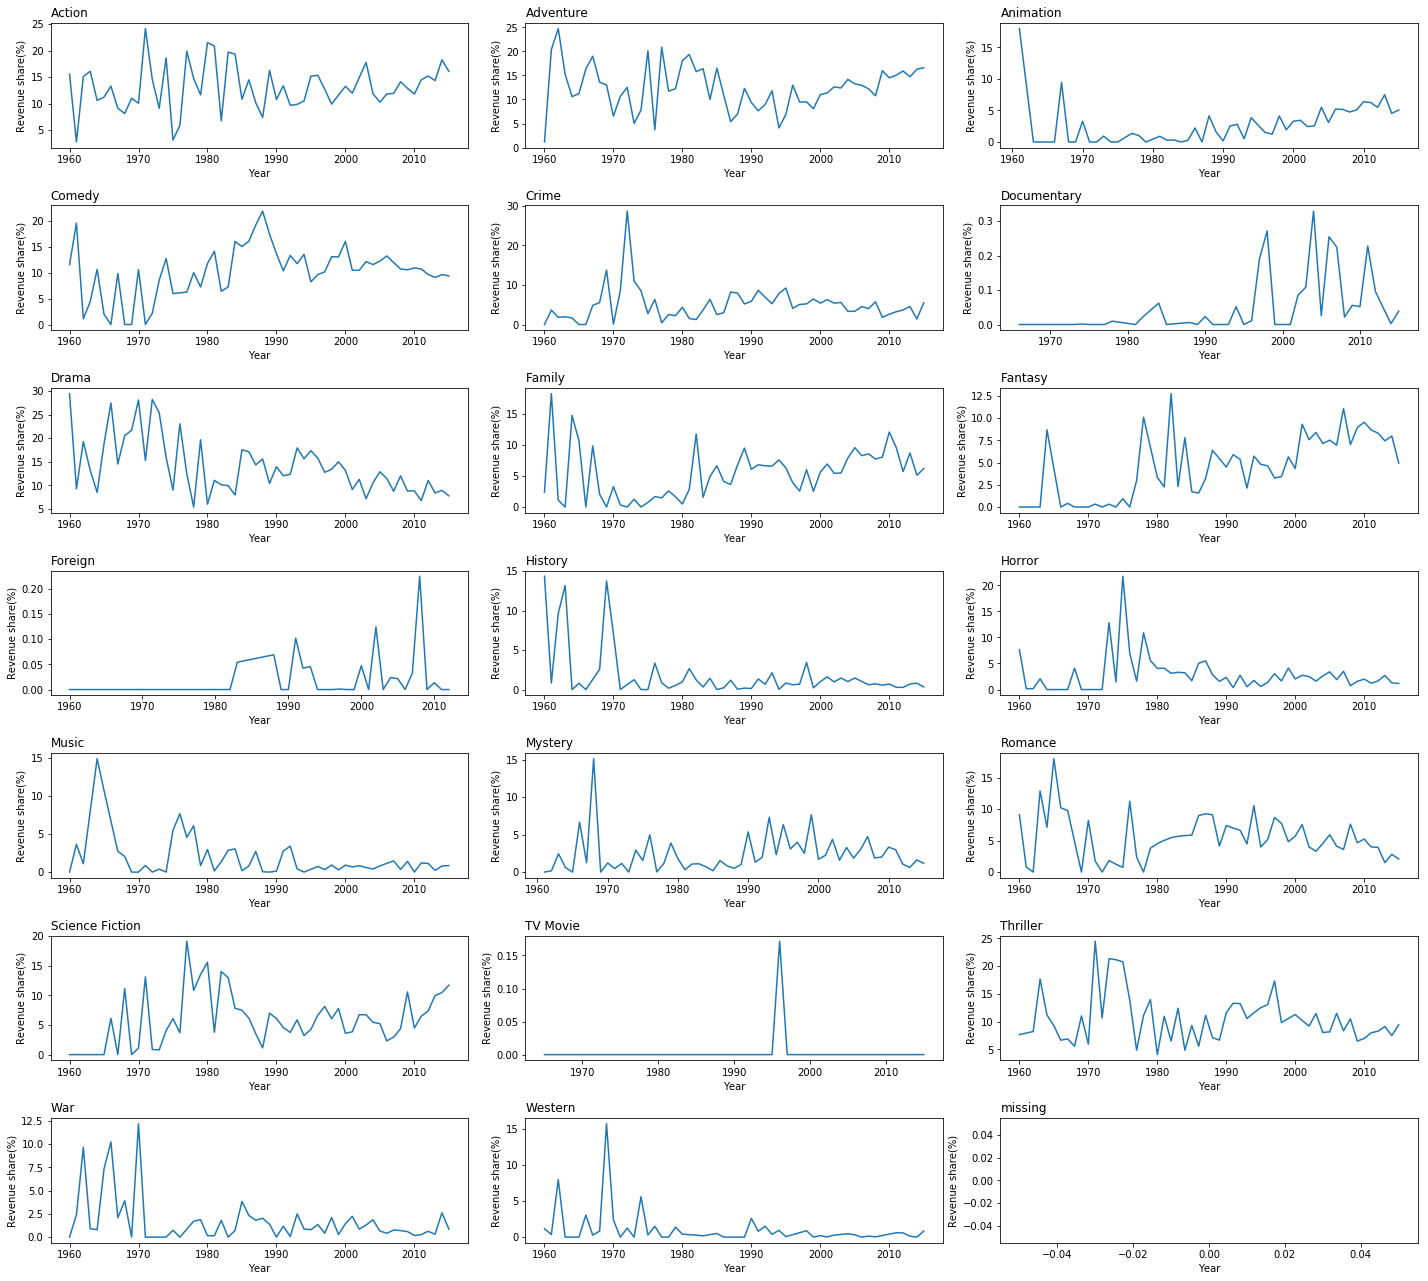

In [9]:
## This will try to plot line charts based on revenue share percentage by genres 

# 1. Split the df based on genres
try:
    df_by_genres
except NameError:
    df_by_genres = build_splitted_df_by_key(df,'genres')

if df_by_genres.empty:
    df_by_genres = build_splitted_df_by_key(df,'genres')
    
# 1. Calculate the total amount of the revenue for each year

total_revenue_by_year = df_by_genres.groupby('release_year').sum()

# 2. Sum the df by genres and release_year
sum_df_by_genres = df_by_genres.groupby(['genres','release_year']).sum()

# 3. merge above DFs to add an new column 'revenue_share' = (revenue of genres)/(the total revenue of year)

## 3-1. rename the column before merge
total_revenue_by_year.rename(columns=lambda x: "yearly_total_"+x[:15], inplace=True)

## 3-2. merge
df_sum_by_genres_with_total = sum_df_by_genres.merge(total_revenue_by_year,left_index=True,right_index=True,how='inner')

## 3-3. add column with the calculated revenue_share
df_sum_by_genres_with_total['revenue_share']= df_sum_by_genres_with_total['revenue_adj']/df_sum_by_genres_with_total['yearly_total_revenue_adj']

# 4. Plot a Line charts

## 4-1. Define the figsize
plt.subplots(figsize=(20, 20))

## 4-2. for each genres, plot a line
genres_list = df_by_genres['genres'].unique()
#print(genres_list)

num=0
for genre in sorted(genres_list):
    num+=1
    df_genre = df_sum_by_genres_with_total.query('genres == "{}" and genres != "missing"'.format(genre)).groupby(['release_year']).revenue_share.sum()*100
    plt.subplot(8,3, num)
    # Add title
    plt.title(genre, loc='left')
    plt.xlabel('Year')
    plt.ylabel('Revenue share(%)')
    plt.tight_layout()
    plt.plot(df_genre)


### Observation
* Although Actions, Adventures shows increasing trend for last 20 years, the change in share is not as drastic as the change in revenue amount.
* Animation, Fantasy, Science Fiction are showing increasing trend in share.
* Crime, Drama, Horror, Music, Mystery, Romance, Thriller are showing decreasing trend.
<BR><BR>
Now let's look into the details in pie charts.

In [10]:
def plot_pie_chart_by_period(df,from_year, to_year,pie_title, key, agg, agg_field):
    """
    This function is to plot a pie chart of revenue share with specified period.
    Parameters:
        df: dataframe to be explored
        from_year, to_year: years to specity from year to year  
        pie_title: string to be used as a graph title
        key: the field to be used as group by key
        agg: group by operation, such as 'sum', 'count', etc.
        agg_field: field to be aggregated
    """
    df.query('{} <= release_year <= {}'.format(from_year,to_year)).groupby(key)[agg_field].agg(agg).plot.pie(sort_columns=True,autopct='%1.1f%%', startangle=90, counterclock=False, pctdistance=0.8, labeldistance=1.2)
    plb.ylabel('')
    plt.title(pie_title)

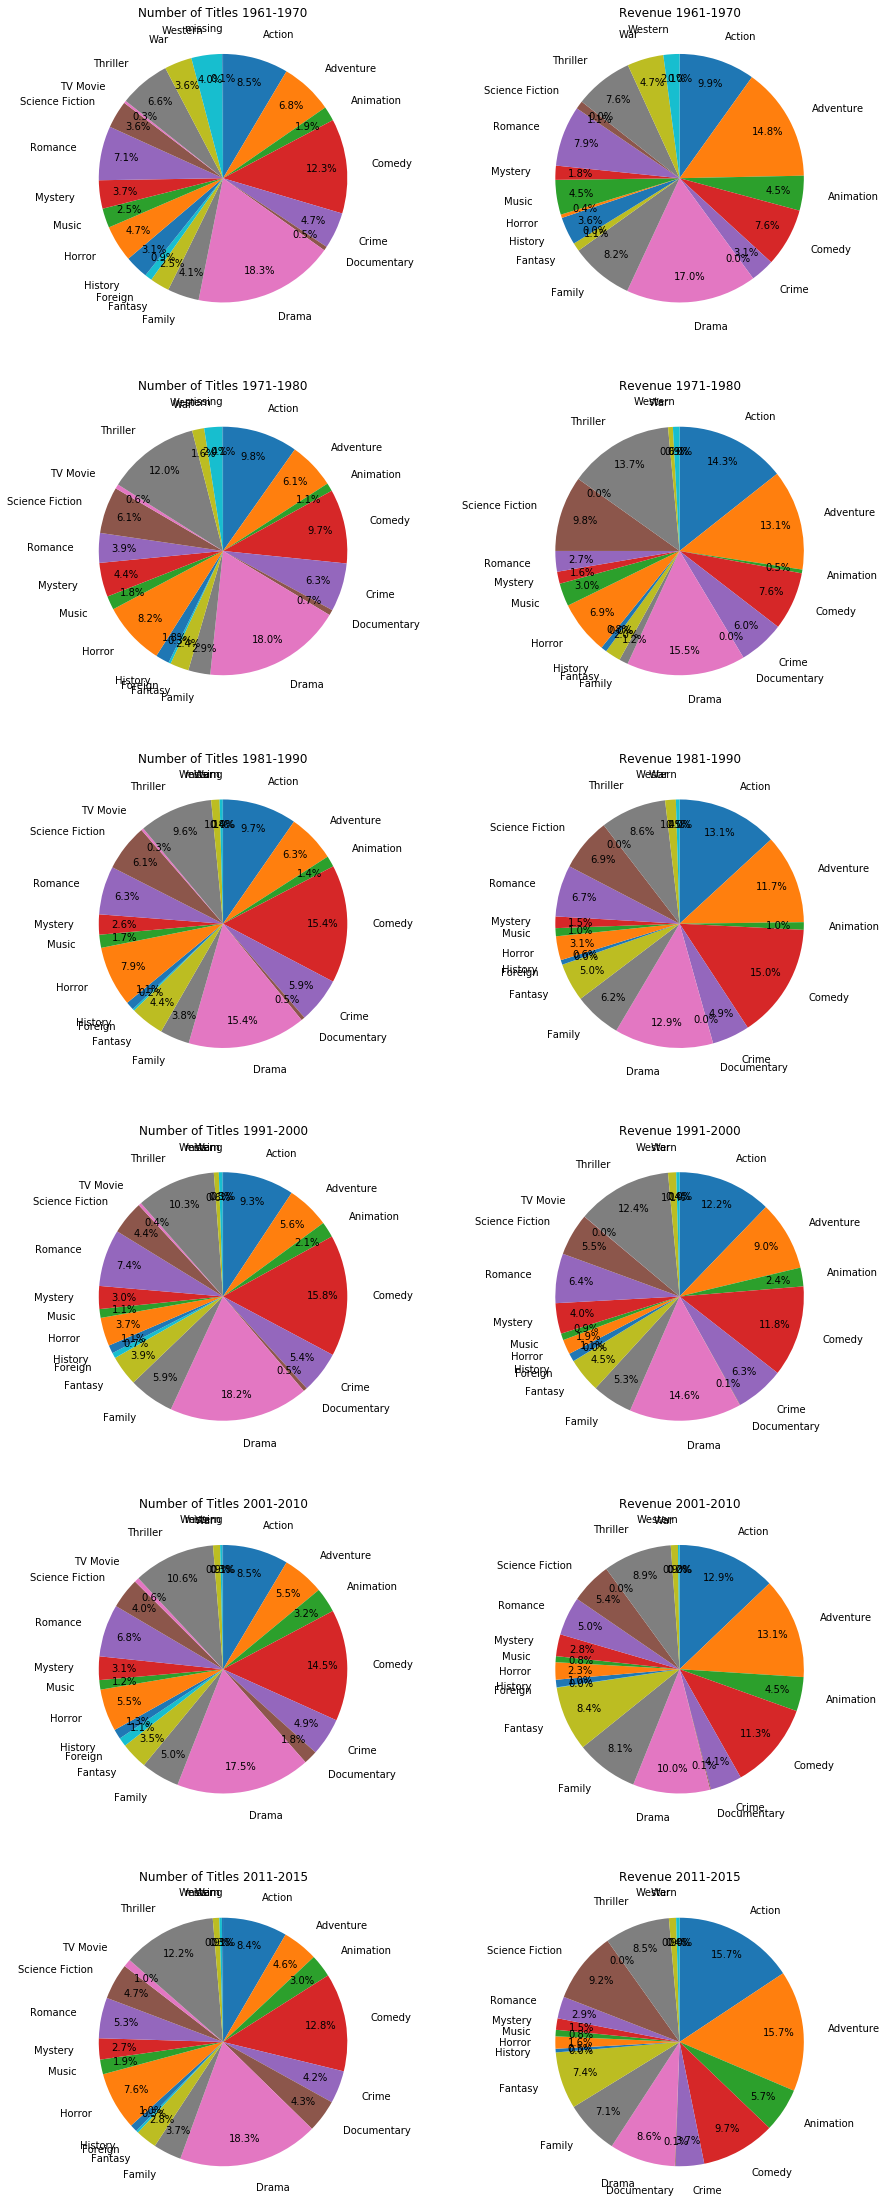

In [11]:
# 1. Split the df based on genres
try:
    df_by_genres
except NameError:
    df_by_genres = build_splitted_df_by_key(df,'genres')

if df_by_genres.empty:
    df_by_genres = build_splitted_df_by_key(df,'genres')

# 2. Draw pie charts  for each decades for both revenue and numberof titles released
i=0
plt.subplots(figsize=(15, 40))
for from_year in [1961, 1971,1981,1991,2001,2011]:
    i +=1
    to_year = from_year + 9
    if to_year > 2015: to_year = 2015
    plt.subplot(6,2,i,  aspect='equal')
    #plot_title_num_pie_chart_by_period(df_by_genres,from_year,to_year,'Number of Titles {}-{}'.format(from_year, to_year),'genres')
    plot_pie_chart_by_period(df_by_genres,from_year,to_year,'Number of Titles {}-{}'.format(from_year, to_year),'genres','count','id')
    i += 1
    plt.subplot(6,2,i,  aspect='equal')
    plot_pie_chart_by_period(df_by_genres,from_year,to_year,'Revenue {}-{}'.format(from_year, to_year),'genres','sum','revenue_adj')

### Observation
In this part, I would like to focus on 2 genres, one is Drama, the other is Animation.<BR>
The left side of pie charts show the share in number of titles released whereas the right side show the share in revenue.

#### Drama
* Drama used to have the largest share both in released titles (18.3) and revenue (17.0%) in 1960s.
* However, its revenue have been decreasing for last 50 years and it dropped to 8.6% in 2010s, despite the percetnage in the number of the released titles have been staying same level around 18% all the time.
<BR>
<BR>
    
#### Animation
* Animationm which once hit its bottom in 1970s with the portion of 1.1% in released titles and 0.5% in revenue. 
* However, its revenue recovered up to 5.7% in 2010s.
* Interstingly, its increase in the number of released titles is less than 2% whereas increase in revenue is 5.2%.

### Research question 3: What are the key words most frequently used from year to year?

Text(0,0.5,'')

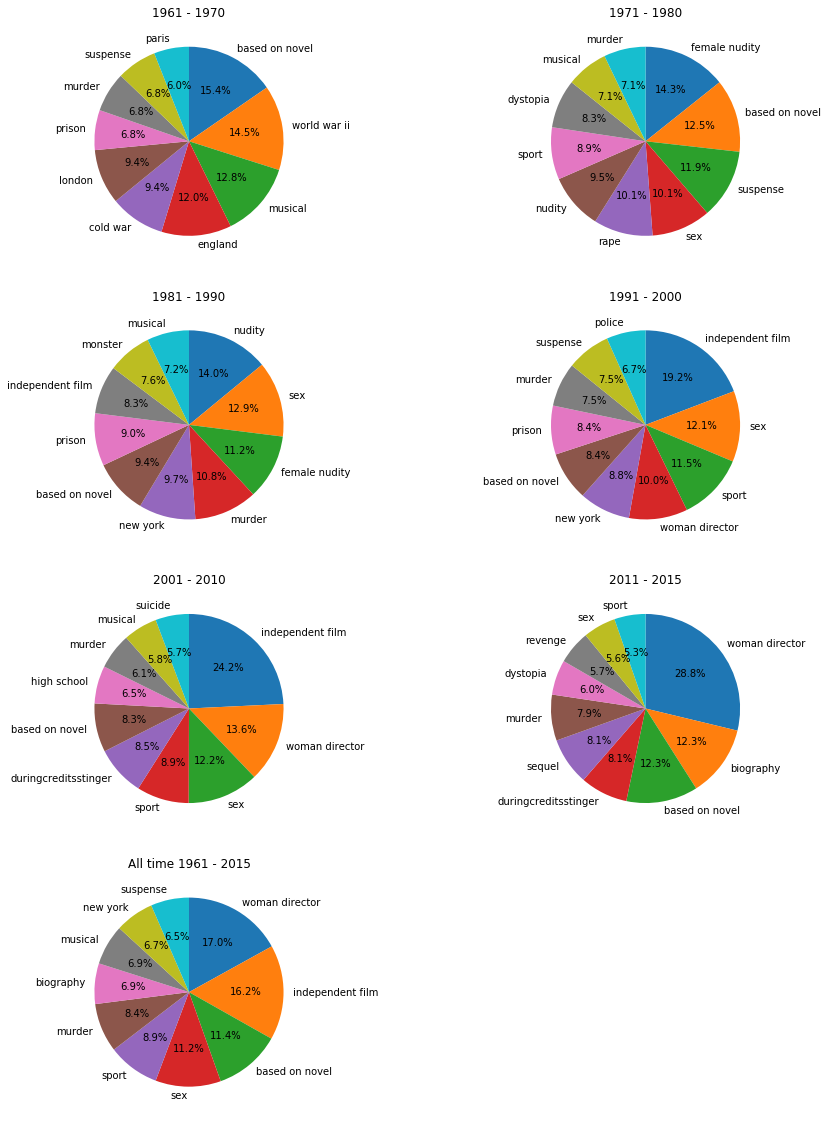

In [12]:
try:
    df_by_keywords
except NameError:
    df_by_keywords = build_splitted_df_by_key(df,'keywords')

if df_by_keywords.empty:
    df_by_keywords = build_splitted_df_by_key(df,'keywords')

plt.subplots(figsize=(15,20))
i=0
agg = 'count'
for from_year in [1961, 1971,1981,1991,2001,2011]:
    to_year = from_year + 9
    if to_year > 2015: to_year = 2015
    i+=1
    df_sum_by_keywords = df_by_keywords.query('keywords != "missing" and {} <= release_year <= {}'.format(from_year, to_year)).groupby(['keywords']).agg(agg)
    plt.subplot(4,2,i,  aspect='equal')
    plt.title('{} - {}'.format(from_year, to_year))
    df_sum_by_keywords['revenue_adj'].sort_values(ascending=False).head(10).plot.pie(sort_columns=True,autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.ylabel('')

# add what are the most commonly seen key words all time
from_year = 1961
to_year = 2015
df_sum_by_keywords = df_by_keywords.query('keywords != "missing" and {} <= release_year <= {}'.format(from_year, to_year)).groupby(['keywords']).agg(agg)
plt.subplot(4,2,i+1, aspect='equal')
plt.title('All time {} - {}'.format(from_year, to_year))
df_sum_by_keywords['revenue_adj'].sort_values(ascending=False).head(10).plot.pie(sort_columns=True,autopct='%1.1f%%', startangle=90, counterclock=False)
plt.ylabel('')


### Observation
Above pie charts show the top 10 most frequently used key words for each decade. Please note the percentage is the proportion within the top 10.
* 'based on novel' constantly appearing in top 10 most frequent keywords.
* Since around 1990s, 'woman director' has been increasing its frequency and now the most frequently used keywords all time. As explored in question 1, this also seems to be affected by the increase in the number of titled released after 1990s.

### Research Question 4 : Who are the directors that earned most revenue from year to year?

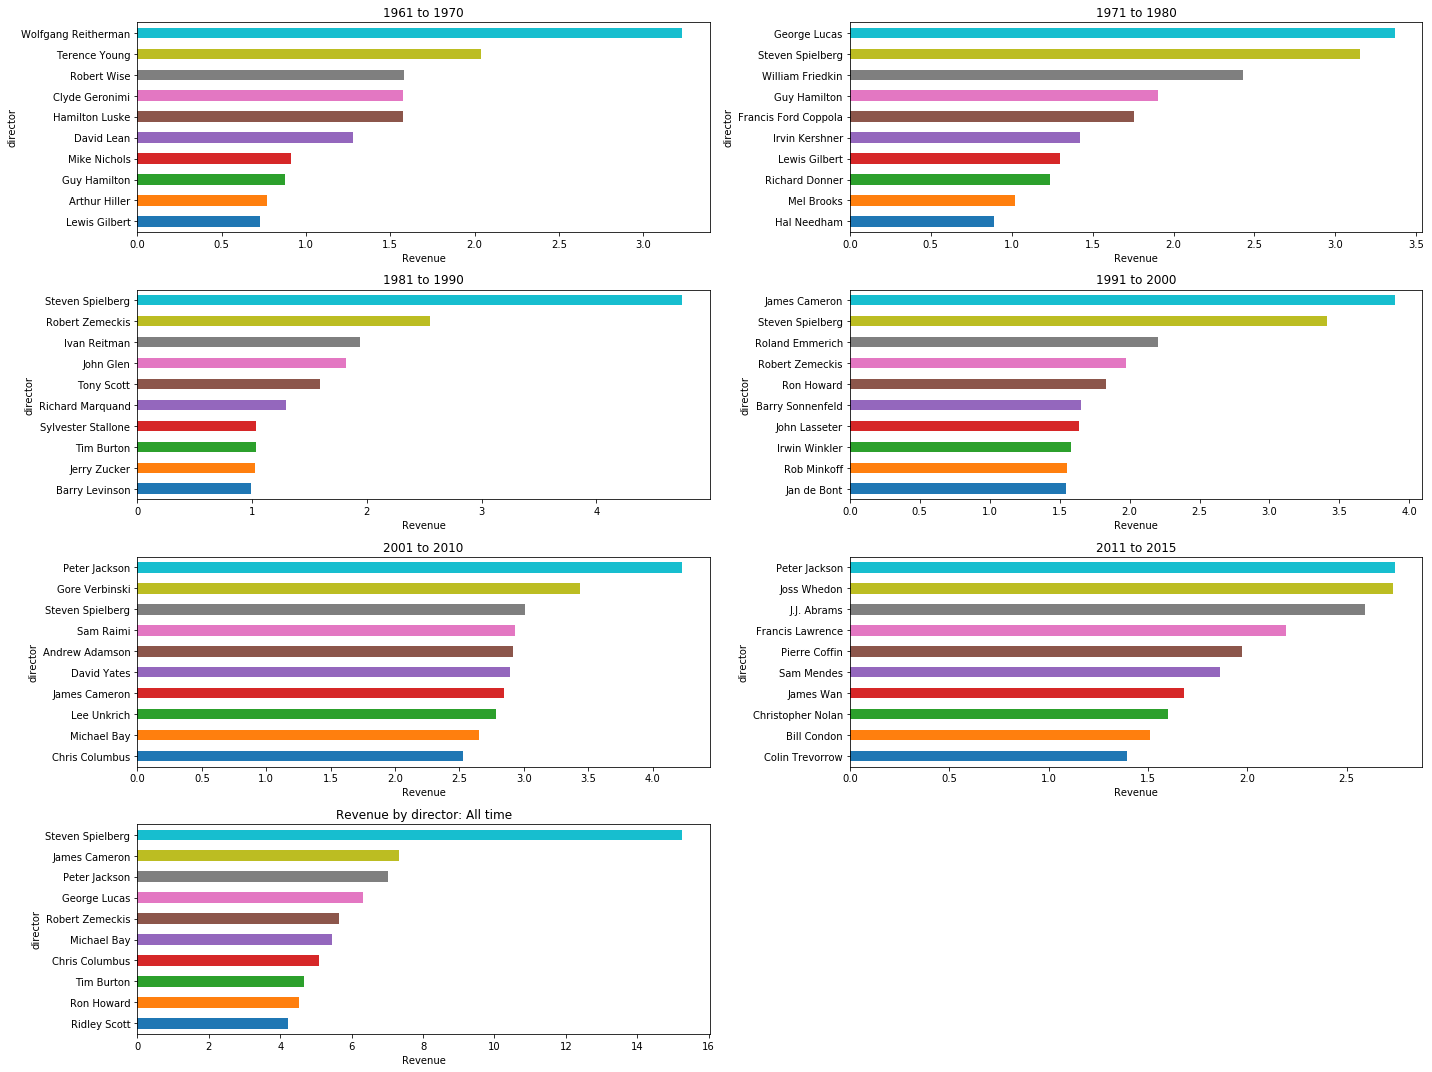

In [13]:
# 1. split the df by 'director'
try:
    df_by_director
except NameError:
    df_by_director = build_splitted_df_by_key(df,'director')

if df_by_director.empty:
    df_by_director = build_splitted_df_by_key(df,'director')

# 2. Most earned directors for each decade
plt.subplots(figsize=(20,15))
i=0
for from_year in[1961,1971,1981,1991,2001,2011]:
    i+=1
    to_year = from_year + 9
    if to_year > 2015: to_year = 2015
    title = '{} to {}'.format(str(from_year),str(to_year))
    plt.subplot(4,2,i)
    plt.xlabel('Revenue')
    plt.tight_layout()
    plot_barh_by_year_and_person(df_by_director, 'director', from_year, to_year,title)
    
# 3. Who is the all time best earner?
from_year = 1955
to_year = 2015
title = 'Revenue by director: All time'
plt.subplot(4,2,i+1)
plt.xlabel('Revenue')
plt.tight_layout()
plot_barh_by_year_and_person(df_by_director,'director',from_year, to_year,title)


### Observation
* The director whose movies earned the most revenue all time is Steven Spielberg, who has been constantly earning 3 billion dollars for every decade and also constantly ranked in top 3 from 1970s to 2000s, followed by James Cameron, Peter Jackson, and George Lucas.
* The revenue earned by each director have been also increasing since after 2000s, the directors ranked in top 10 between 2001-2011 all earned more than 2 billion dollars, most of the directors ranked in top 10 between 2011-2015 have earned morethan 1.5 billion in 5 years period, in cotranst with the directors before 1980s, most of them earned less than 2 billion per decade.
* This is also seem to be affected by the drastic increase in the numver of released titles after 2000s.

### Research Question 5: Who are the directors that earned highest rating?

,title_count,average_rating,revenue_adj
director,,,
Quentin Tarantino,14,7.207143,1889247098
Wes Anderson,13,7.200000,427467258
Martin Scorsese,31,6.970968,2426541974
Joel Coen,17,6.952941,1089111368
Danny Boyle,12,6.941667,819477940
Peter Jackson,14,6.885714,7019847812
Jim Jarmusch,11,6.845455,63662942
Roman Polanski,17,6.829412,736698248
James Cameron,11,6.800000,7327220854


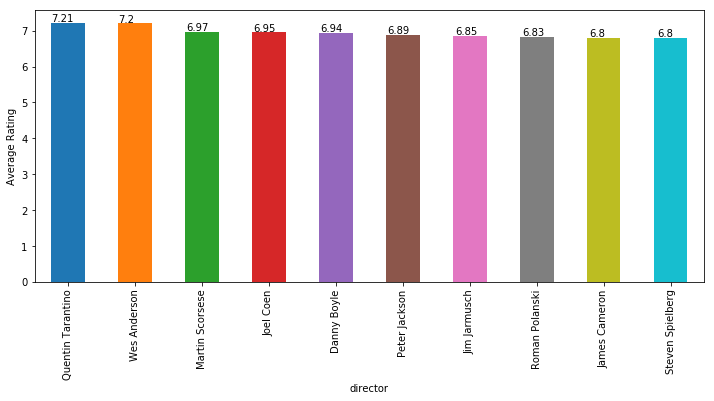

In [15]:
try:
    df_by_director
except NameError:
    df_by_director = build_splitted_df_by_key(df,'director')

if df_by_director.empty:
    df_by_director = build_splitted_df_by_key(df,'director')

# 1. filter out the movies without director information and aggregate by director
df_ratings_sum_by_director = df_by_director.query('director != "missing"').groupby(['director']).agg({'id':'count','vote_average':'mean','revenue_adj':'sum'})
df_ratings_sum_by_director = df_ratings_sum_by_director.rename(index=str, columns={"id": "title_count", "vote_average": "average_rating"})

# 2. filter out the directors who did not release more than 10 movies to eliminate the directors who earned high rating with fewer movies.
top10 = df_ratings_sum_by_director.query('title_count > 10').sort_values(by='average_rating',ascending=False).head(10)

plt.subplots(figsize=(12,5))
plt.ylabel('Average Rating')
ax=top10.average_rating.sort_values(ascending=False).plot.bar()
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
top10.head(10)

### Observation
In this analysis, the directors who does not release more than 10 titles are intentionally eliminated in order to find the directors that are constantly producing high rating movies.

* Quentine Tarantino is the director whose movies earned the highest rating in average.  Tarantino has rating of 7.21 in average, over his 14 movie titles, followed by Wes Anderson, Martin Scorsese, Joel Coen, and so on.
* Interestingly, high rating does not always seem to come with high revenue. Only 3 of the directors with the highest revenue are in top 10.

### Research Question 6: Who are the actors most frequently casted?

In [16]:
def plot_most_casted_actors(from_year, to_year, title):
    df_count_by_cast = (df_by_cast.query('cast != "missing" and {} < release_year <= {}'.format(str(from_year),str(to_year))).groupby(['cast']).id.count()).sort_values(ascending=False).head(10)
    df_count_by_cast.sort_values(ascending=True).plot(kind='barh')
    plt.title(title)


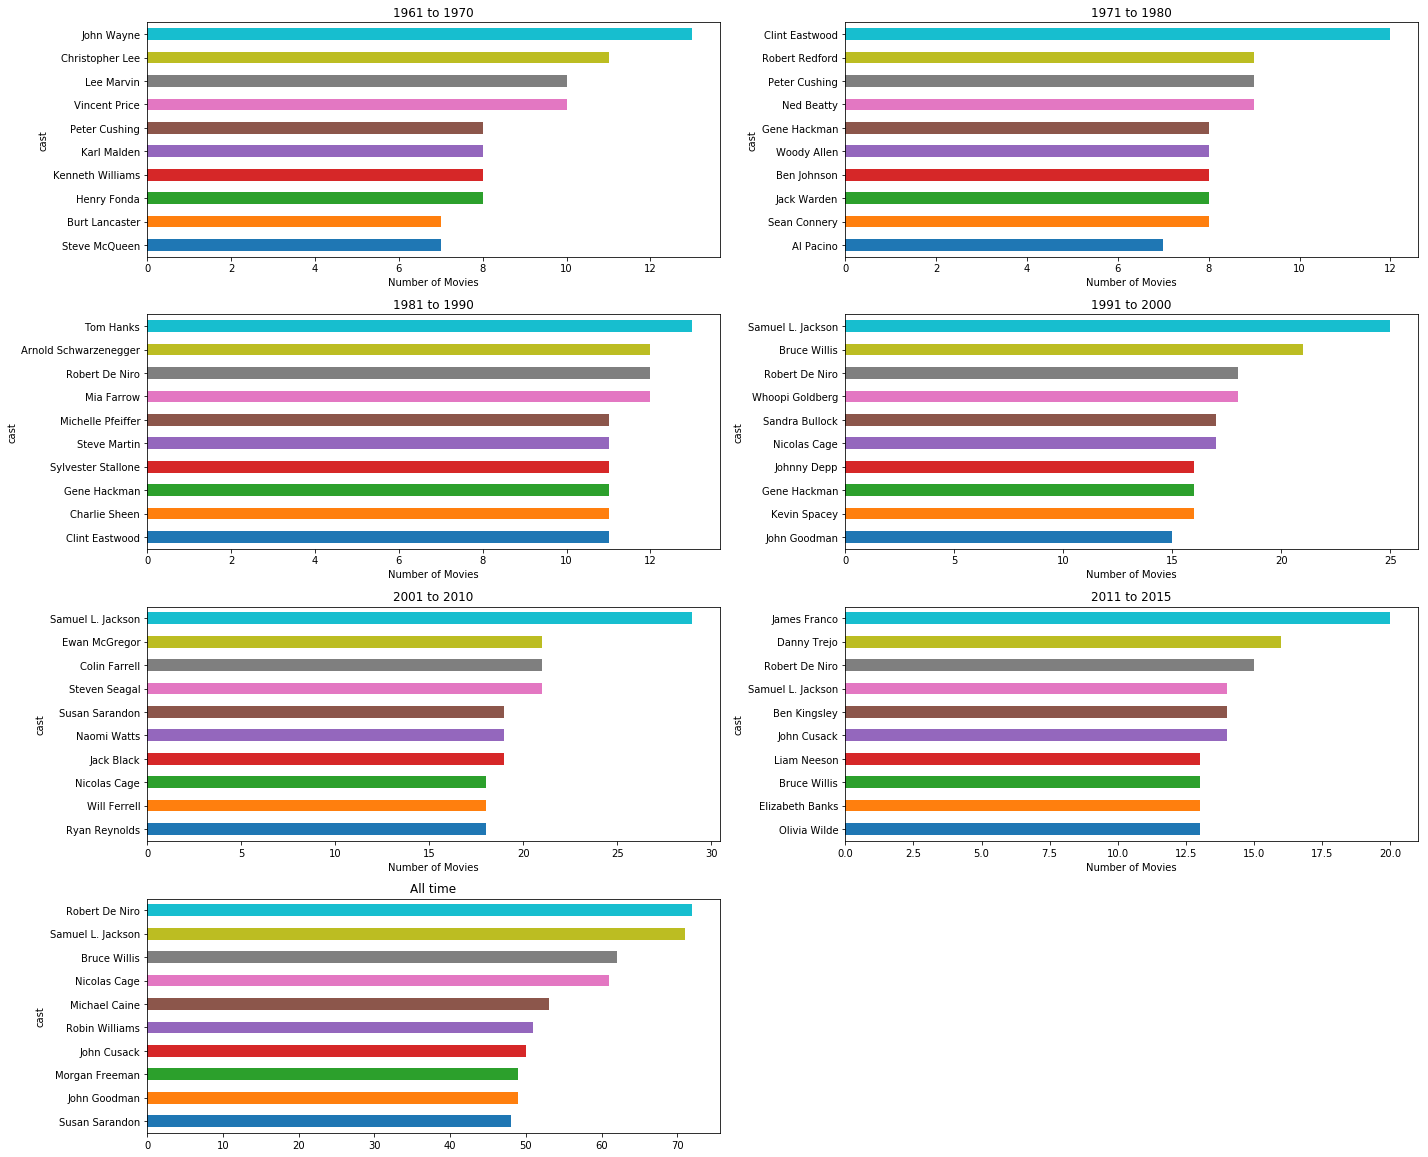

In [17]:
# 1, Split the dataframe by cast field
try:
    df_by_cast
except NameError:
    df_by_cast = build_splitted_df_by_key(df,'cast')

if df_by_cast.empty:
    df_by_cast = build_splitted_df_by_key(df,'cast')

# 2. Most casted actors for each decade
plt.subplots(figsize=(20,20))
i=0
for from_year in [1961,1971,1981,1991,2001,2011]:
    i+=1
    to_year = from_year +9
    if to_year > 2015: to_year = 2015
    title = '{} to {}'.format(str(from_year),str(to_year))
    plt.subplot(5,2,i)
    plt.xlabel('Number of Movies')
    plt.tight_layout()
    plot_most_casted_actors(from_year, to_year,title)
    
# 3. Who is the most casted actor all the time?
from_year = 1950
to_year = 2015
title = 'All time'
plt.subplot(5,2,i+1)
plot_most_casted_actors(from_year, to_year,title)

### Observation
* The most frequently casted actor all time is Robert De Niro, followed by Samuel L. Jackson, and Bruce Willis.
* As we have explored in question 1, increase in the number of released movies also seems to be affecting this ranking.
    * In 1960s, the most frequently casted actor was John Wayne who appeard on 14 movies in 10 years period.
	* In 2000s, the most frequently casted actor was Samuel L. Jackson who were casted in nearly 30 movies in 10 years period. James Franco, who is ranked on top between 2011-2015, is casted in about 20 movies only in 5 years.
    * Most of the actors ranked in all time top 10 are mostly casted in the movies released after 1990s.

<a id='conclusions'></a>
## Conclusions

#### Limitations
Due to the limited information available from this dataset, there are some limitations as follows:
1. Records with 0 amount
    * There are many records whose budget or revenue fields have amount of 0 dollars, that seems to be highly unlikely in reality.
    * Such records with 0 amount were eliminated when calculating the mean for more accurate analysis.
2. Missing values
    * As stated in the data wrangling section, many fields used in this analysis have missing values, such as genres, director, cast, keywords, etc.
    * Such records with missing values were eliminated when calculating shares in revenue or number of released movies.

#### Findings
Although there are some correlation observed among the properties and following research results also seems to be supporting the direction, it is not possible to determine the actual cause of the observed phenomenons.
It might be premature to conlude, however, findings in this research are as follows:
* As explored in question 1, drastic increase in number of release since around mid 1990s seem to have major impact to various properties. 
* Rating seems to be the only exception as seen in question 5.
* It may imply that the recent increase in revenue movie industry is more relying on the number of release than the rating of each movie.
